In [1]:
import numpy as np
import torch
import torch.nn as nn

from pfi.utils import load_data, X_from_snapshots, SpectralNormDNN, DNN
from pfi.score import ScoreMatching
from pfi.flow import FlowRegression
from pfi.flow.models import CLEFlow
from pfi.flow.interpolants import ChebyshevInterpolant

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


device(type='cuda')

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

nsamples = 6000
Np = 150
Nf = 150
L = 5
fac = 2
nmb = 1
lx = 0.7

# Use longer runs to align with MultiStepLR milestones used in the solvers
score_epochs = 5000
flow_epochs = 2000


In [3]:
path = '/mnt/home/vchardes/ceph/datasets/HSC_data/10XChromiumV3_10.1038_s41467-021-27159-x_10.5281_zenodo.5291737_exvivo.h5ad'
genes = ['fli1', 'klf1', 'gata1', 'gata2', 'gfi1b', 'runx1', 'tal1', 'jun', 'spi1', 'zfpm1', 'lmo2', 'etv6', 'erg', 'mef2c']

samples, times, ind_array, cell_types = load_data(
    path=path,
    nsamples=nsamples,
    genes=genes,
    time_key='day',
    cell_type_key='cell_type',
    seed=seed,
)

X = X_from_snapshots([samples[k] for k in range(samples.shape[0])], times)
ndim = X.shape[1] - 1
print('X shape:', X.shape, 'ndim:', ndim, 'times:', times)


X shape: (36000, 15) ndim: 14 times: [ 0  2  4  6  8 11]


In [4]:
score_model = DNN(
    sizes=[ndim + 2, Np, Np, Np, Np, Np, ndim],
    activation=nn.ELU(),
).to(device)

score_reg = ScoreMatching(
    model=score_model,
    solver='dsm',
    solver_kwargs=dict(L=L, 
                       lr=1e-2, 
                       n_epochs=score_epochs, 
                       bs=nsamples, 
                       adp_flag=1),
    device=device,
)
score_reg.fit(X)


/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain = torch.tensor(x_train, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(x_data, dtype=torch.float32).to(device)
DSM:   0%|          | 8/5000 [00:00<04:51, 17.10it/s, los

epoch: 0 c_: [0.16149011 0.16479315 0.16389608 0.16784753 0.17056194 0.17141111]


DSM:  10%|█         | 505/5000 [00:15<02:21, 31.73it/s, loss=1.207e+00, lr=1.00e-02]

epoch: 500 c_: [0.14447854 0.15220977 0.17093341 0.19469579 0.18820791 0.14947458]


DSM:  20%|██        | 1010/5000 [00:31<01:45, 37.76it/s, loss=1.079e+00, lr=1.00e-02]

epoch: 1000 c_: [0.1149564  0.17471504 0.17086017 0.1904367  0.18994813 0.15908352]


DSM:  30%|███       | 1508/5000 [00:46<01:36, 36.02it/s, loss=1.095e+00, lr=1.00e-02]

epoch: 1500 c_: [0.08662314 0.12525982 0.18322861 0.21604326 0.21089569 0.1779495 ]


DSM:  40%|████      | 2005/5000 [01:01<01:34, 31.71it/s, loss=1.050e+00, lr=1.00e-02]

epoch: 2000 c_: [0.09830665 0.130037   0.18491521 0.20625408 0.20401792 0.17646912]


DSM:  50%|█████     | 2510/5000 [01:16<01:06, 37.66it/s, loss=9.439e-01, lr=1.00e-03]

epoch: 2500 c_: [0.2661112  0.18204708 0.14794327 0.14448586 0.13965558 0.119757  ]


DSM:  60%|██████    | 3008/5000 [01:31<00:55, 36.09it/s, loss=9.667e-01, lr=1.00e-03]

epoch: 3000 c_: [0.2223421  0.06088576 0.10106954 0.27911308 0.16420397 0.1723856 ]


DSM:  70%|███████   | 3505/5000 [01:46<00:47, 31.76it/s, loss=9.583e-01, lr=1.00e-03]

epoch: 3500 c_: [0.23340084 0.05191413 0.09372934 0.29138008 0.14412732 0.18544835]


DSM:  80%|████████  | 4010/5000 [02:02<00:26, 37.77it/s, loss=9.467e-01, lr=1.00e-03]

epoch: 4000 c_: [0.24129228 0.04531543 0.0859154  0.28942496 0.12800552 0.2100464 ]


DSM:  90%|█████████ | 4508/5000 [02:17<00:13, 35.99it/s, loss=9.336e-01, lr=1.00e-03]

epoch: 4500 c_: [0.1571679  0.08406153 0.12916064 0.2387856  0.18333611 0.20748824]


DSM: 100%|██████████| 5000/5000 [02:32<00:00, 32.84it/s, loss=9.112e-01, lr=1.00e-03]


/mnt/home/vchardes/pfi/pfi/score/_base.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = torch.tensor(init_, dtype=torch.float32).to(device)


[KeOps] Generating code for formula Sum_Reduction(-Sqrt(Sum((Var(0,14,0)-Var(1,14,1))**2))*Var(2,1,1),0) ... 

/mnt/home/vchardes/pfi/pfi/score/_base.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_t, dtype=torch.float32, device=self.device),


OK


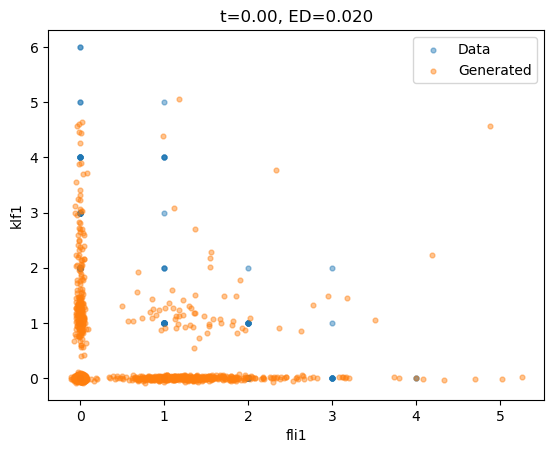

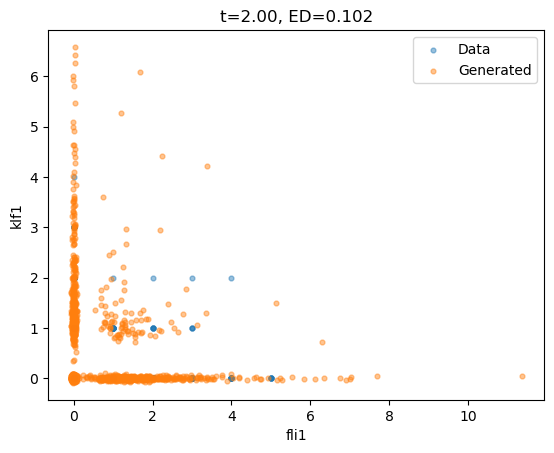

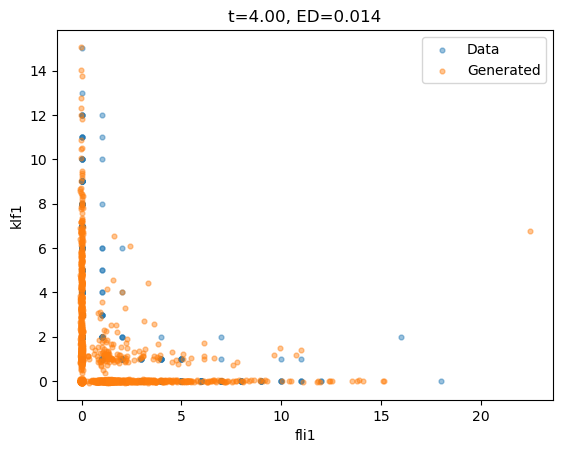

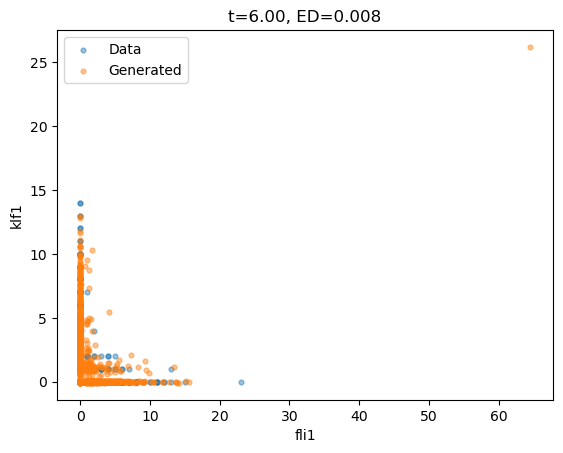

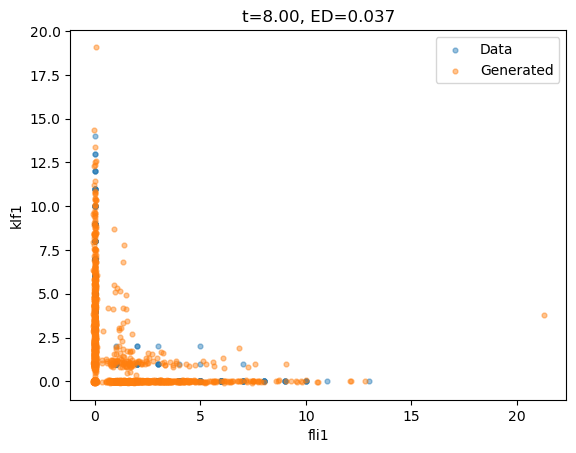

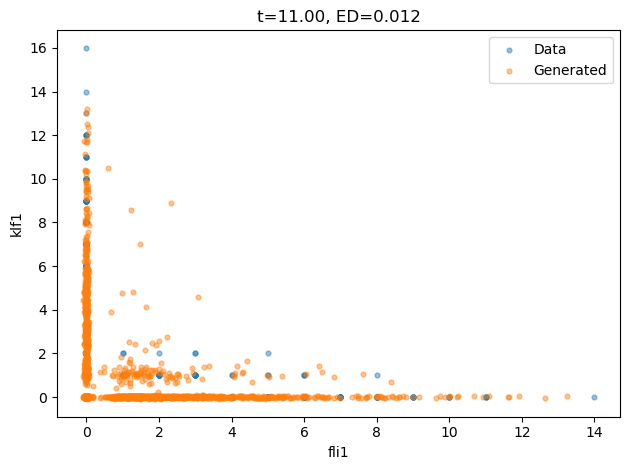

ED per time: [0.02014446 0.10220671 0.01407814 0.00811052 0.03736591 0.01166582]


In [5]:
# Validate score model: generated samples vs observed snapshots + ED
import matplotlib.pyplot as plt

times_eval = np.unique(X[:, -1])
ed_score = score_reg.score(X, maxiter=100)

ncols = min(4, len(times_eval))
nrows = int(np.ceil(len(times_eval) / ncols))
#fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))

for k, t in enumerate(times_eval):

    fig, ax = plt.subplots()
    xk = X[X[:, -1] == t][:2000]
    gen = score_reg.sample(xk, nsamples=xk.shape[0], maxiter=100)

    ax.scatter(xk[:, 0], xk[:, 1], s=12, alpha=0.45, label='Data')
    ax.scatter(gen[:, 0], gen[:, 1], s=12, alpha=0.45, label='Generated')
    ax.set_title(f't={t:.2f}, ED={ed_score[k]:.3f}')
    ax.set_xlabel(genes[0])
    ax.set_ylabel(genes[1])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

print('ED per time:', ed_score)


In [6]:
drift_model = SpectralNormDNN(
    sizes=[ndim, Nf, Nf, Nf, Nf, ndim],
    activation=nn.ELU(),
).to(device)

cle_model = CLEFlow(
    net=drift_model,
    score=score_reg.model_,
    Ndim=ndim,
    lx=lx,
)

flow_reg = FlowRegression(
    interp=ChebyshevInterpolant(device=device),
    model=cle_model,
    growth_model=None,
    solver='fm',
    solver_kwargs=dict(fac=fac, 
                       nb=nmb, 
                       n_epochs=flow_epochs, 
                       lr=1e-2),
    device=device,
)
flow_reg.fit(X)


/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


6000 1500
[lambda-selection] Initial error: 0.2144
[lambda-selection] Best lambda (>=80% drop): 0.4000
[lambda-selection] Vel magnitudes: [0.21439546 0.19707389 0.1835252  0.16400939 0.12999523 0.10312174
 0.08818499 0.07808293 0.05582467 0.04458664 0.03762931 0.03286156
 0.02454892 0.02131497]


FM:   0%|          | 0/2000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Dist = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32, device=device)
FM:   0%|          | 5/2000 [00:00<01:35, 20.99it/s, loss=1.910e+00, lr=1.00e-02]

[epoch 0] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  25%|██▌       | 505/2000 [00:15<00:44, 33.54it/s, loss=8.333e-01, lr=1.00e-02]

[epoch 500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  50%|█████     | 1005/2000 [00:29<00:29, 33.68it/s, loss=3.594e-01, lr=1.00e-03]

[epoch 1000] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM:  75%|███████▌  | 1505/2000 [00:44<00:14, 33.73it/s, loss=3.411e-01, lr=1.00e-04]

[epoch 1500] inferred mass=[1.0000002 1.0000002 1.0000002 1.0000002 1.0000002 1.0000002] actual mass=tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')


FM: 100%|██████████| 2000/2000 [00:59<00:00, 33.87it/s, loss=3.800e-01, lr=1.00e-04]


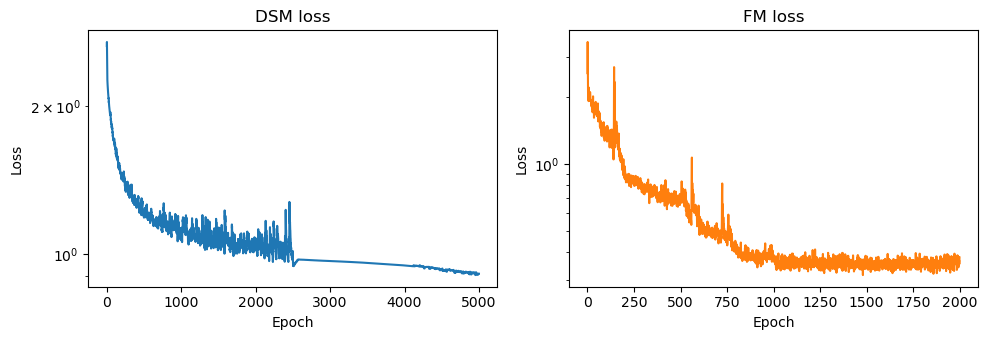

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].plot(score_reg.loss_, lw=1.5)
ax[0].set_title('DSM loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(flow_reg.loss_, lw=1.5, color='tab:orange')
ax[1].set_title('FM loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()
